In [168]:
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import mean_squared_error as mse
import operator

import math
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers


def load_animal_data():

    animals_data = np.genfromtxt('data_lab2/animals.dat', delimiter=',')
    animals_data.shape = (32, 84)

    animal_names = np.genfromtxt('data_lab2/animalnames.txt', dtype='str')

    for i in range(len(animal_names)):

        animal_names[i] = animal_names[i].replace("'","")

    return animals_data, animal_names

def load_mp_data():

    mp_votes = np.genfromtxt('data_lab2/votes.dat', delimiter=',')
    mp_votes.shape = (349, 31)

    mp_party = np.genfromtxt('data_lab2/mpparty.dat', comments="%")

   
    return mp_votes, mp_party


class SOM():
    def __init__(self, nodes, dims):
        self.nodes = np.random.rand(nodes[0],nodes[1])
        self.num_nodes = nodes[0]
        self.dims = dims
        
        if dims == 2:
            self.height = nodes[0]
        else:
            self.height = self.width = int(np.sqrt(nodes[0]))
    
    def similarity(self, x, nodes):
        min_dist = 99999
        min_idx = 0
        for row in range(self.num_nodes):
            sim = np.linalg.norm(x - nodes[row])
            if (sim < min_dist):
                min_dist = sim
                min_idx = row
        return min_idx, min_dist
    
    def update_weights(self, x, eta, i):
        self.nodes[i] = self.nodes[i] + eta*(x - self.nodes[i])
        
    def update_neighboors(self, x, winner_idx, nbhd_size, eta, circular = False):
       
        if self.dims == 2:
            for i in range(max(0,winner_idx-nbhd_size),min(winner_idx+nbhd_size,self.num_nodes)):
                    self.update_weights(x,eta,i)

            if circular == True:
                print("asfg")
                
        else:
            winner_i = winner_idx // self.height
            winner_j = winner_idx % self.width
            
            for i in range(max(0,winner_i-nbhd_size),min(winner_i+nbhd_size,self.height)):
                for j in range(max(0,winner_j-nbhd_size),min(winner_j+nbhd_size,self.width)):
                    self.update_weights(x,eta,i*self.height+j)
                

    def train(self, X, init_nbhd_size, n_epochs, eta, circular = False):
        
        nbhd_size = init_nbhd_size
        
        for epoch in range(n_epochs):
            for i in range(len(X)):
                min_idx, min_dist = self.similarity(X[i,:],self.nodes)
                self.update_neighboors(X[i,:],min_idx,int(round(nbhd_size)),eta,circular)
            nbhd_size = nbhd_size - init_nbhd_size/n_epochs

    
    def run(self, X, labels):
        results = dict()
        
        if self.dims == 2:
            for i in range(len(X)):
                min_idx, min_dist = self.similarity(X[i,:],self.nodes)
                results[labels[i]] = min_idx
                #print(labels[i],"is represented best by node:",min_idx)
        else:
            for i in range(len(X)):
                min_idx, min_dist = self.similarity(X[i,:],self.nodes)
                if min_idx not in results:
                    results[min_idx] = [labels[i]]
                else:
                    results[min_idx].append(labels[i])
        return results  
    
    


In [115]:
data, names = load_animal_data()
network = SOM([100,84],2)

network.train(data,50,20,eta=0.2)
results = network.run(data,names)
print(sorted(results.items(), key=operator.itemgetter(1)))

[('dragonfly', 0), ('grasshopper', 0), ('beetle', 1), ('butterfly', 1), ('housefly', 4), ('moskito', 4), ('spider', 10), ('duck', 16), ('pelican', 16), ('penguin', 20), ('ostrich', 24), ('frog', 30), ('crocodile', 36), ('seaturtle', 36), ('walrus', 45), ('bear', 50), ('hyena', 56), ('dog', 60), ('cat', 66), ('lion', 66), ('ape', 71), ('skunk', 74), ('bat', 77), ('rat', 77), ('elephant', 80), ('rabbit', 84), ('kangaroo', 87), ('antelop', 91), ('horse', 94), ('camel', 96), ('giraffe', 96), ('pig', 99)]


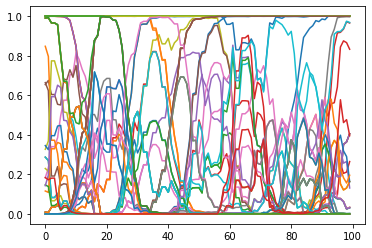

In [116]:
plt.plot(network.nodes)

In [117]:
votes, parties = load_mp_data()

print(votes.shape,parties.shape)

network = SOM([100,31],3)

network.train(votes,3,20,eta=0.2)

(349, 31) (349,)


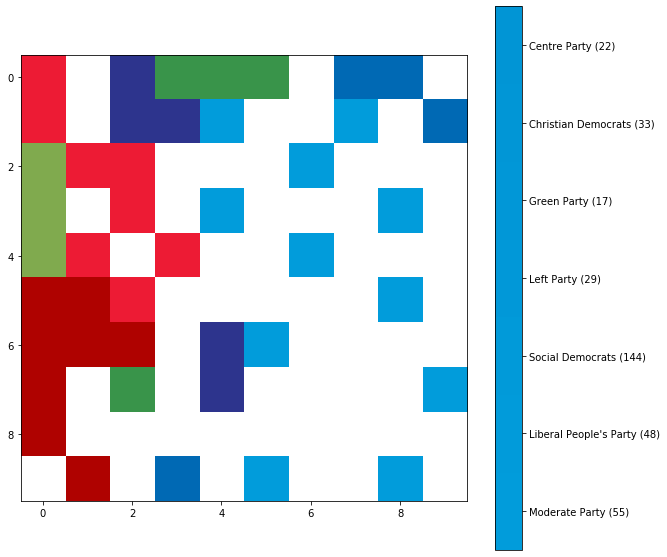

In [214]:
res_by_party = network.run(votes,parties)
# print(collections.Counter(parties))


party_dist = np.zeros([10,10])
for key, value in res_by_party.items():
    party_dist[key//10,key%10] = max(set(value), key=value.count)
np.set_printoptions(threshold=np.inf)

party_dist[party_dist == 0] = float('NaN')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
n = 7
cmap = LinearSegmentedColormap.from_list('mycmap', ['#019CDB', '#0069b4', '#ed1b34', '#b00000', \
                                                   '#80AA4E', '#2D338E', '#39944A'])
cmap.set_bad(color="white")

norm= matplotlib.colors.BoundaryNorm(np.arange(0,n+1)-0.5, n)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
q = plt.colorbar(sm, ticks=[np.arange(0,n)])
q.set_ticklabels(["Moderate Party (55)","Liberal People's Party (48)","Social Democrats (144)", \
                  "Left Party (29)","Green Party (17)","Christian Democrats (33)","Centre Party (22)"])
plt.imshow(party_dist, cmap=cmap)
